In [1]:
import random
import pandas as pd
import json
import numpy as np
import scipy.sparse as sp
import time
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)

from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

import sys
sys.path.insert(0, '../src')

import preprocess
import evaluation
import utils

In [2]:
def create_surprise_paper_paper_data_from_tsv(datafilename,datadir="../dblp-ref/4fold"):
    itemList, userList, ratingList = [], [], []

    df = pd.read_table(datadir+"/"+datafilename,
                       usecols=[0, 1, 2],
                       names=['userID', 'itemID', 'rating'],
                       na_filter=False)
    reader = Reader(rating_scale=(0,1))

    data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

    return data

In [3]:
train1 = create_surprise_paper_paper_data_from_tsv("4fold_0_train.tsv").build_full_trainset()
temp   = create_surprise_paper_paper_data_from_tsv("4fold_0_val.tsv"  ).build_full_trainset()
test1  = temp.build_testset()
trainest1 = train1.build_testset()

# train2 = create_surprise_paper_paper_data_from_tsv("4fold_1_train.tsv").build_full_trainset()
# temp   = create_surprise_paper_paper_data_from_tsv("4fold_1_val.tsv"  ).build_full_trainset()
# test2  = temp.build_testset()
# trainest2 = train2.build_testset()

# train3 = create_surprise_paper_paper_data_from_tsv("4fold_2_train.tsv").build_full_trainset()
# temp   = create_surprise_paper_paper_data_from_tsv("4fold_2_val.tsv"  ).build_full_trainset()
# test3  = temp.build_testset()
# trainest3 = train3.build_testset()

# train4 = create_surprise_paper_paper_data_from_tsv("4fold_3_train.tsv").build_full_trainset()
# temp   = create_surprise_paper_paper_data_from_tsv("4fold_3_val.tsv"  ).build_full_trainset()
# test4  = temp.build_testset()
# trainest4 = train4.build_testset()

In [4]:
print(len(train1.all_items()))
print(len(train1.all_users()))

337160
47018


In [5]:
temp   = create_surprise_paper_paper_data_from_tsv("4fold_test.tsv"  ).build_full_trainset()
testset  = temp.build_testset()

In [6]:
def create_test_dict(test):
    result = dict()

    for uid, iid, _ in test:
        try:
            result[uid].append(iid)
        except KeyError:
            result[uid] = []
            result[uid].append(iid)
    return result

In [ ]:
factors_to_try = [10,25,50,75,100,125,150]
rmse_train = np.zeros(len(factors_to_try))
rmse_test = np.zeros(len(factors_to_try))
elapsed_time = np.zeros(len(factors_to_try))

for i in range(len(factors_to_try)):
    nfactors = factors_to_try[i]
    
    t = time.time()
    # First fold
    algo = SVD(biased=False, n_epochs = 100, n_factors = nfactors)
    algo.fit(train1)
    testpredictions  = algo.test(test1, clip=False)
    trainpredictions  = algo.test(trainest1, clip=False)
    
    rmse_test[i]  = accuracy.rmse(testpredictions )
    rmse_train[i] = accuracy.rmse(trainpredictions)
    
    elapsed_time[i] = time.time() - t
    print(rmse_test[i], 'time = ', elapsed_time[i])

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(9,6))

axes.plot(factors_to_try, rmse_test,  '-*', label="Validation")
axes.plot(factors_to_try, rmse_train, '-*', label="Train")
axes.set_title('Effect of nfactors')
axes.set_xlabel('number of factors')
axes.set_ylabel('rmse')
axes.legend()
fig.savefig('svd_rmse_nfactors.eps')

# fig, axes = plt.subplots(1,1,figsize=(9,6))

# axes.plot(factors_to_try, rmse_train,  '-*', label="train")
# axes.set_title('Effect of nfactors')
# axes.set_xlabel('number of factors')
# axes.set_ylabel('rmse')
# axes.legend()
# fig.savefig('svd_rmse_nfactors_train.eps')

In [ ]:
nfactors = 10
reg_lambdas = 10**np.linspace(-6,1,8)
rmse_train_lambda = np.zeros(len(reg_lambdas))
rmse_test_lambda  = np.zeros(len(reg_lambdas))
elapsed_time = np.zeros(len(reg_lambdas))
for i in range(len(reg_lambdas)):
    reg_lambda = reg_lambdas[i]
    
    t = time.time()
    algo = SVD(biased=False, n_epochs = 100, n_factors = nfactors, reg_all=reg_lambda)
    algo.fit(train1)
    elapsed_time[i] = time.time() - t
    
    testpredictions  = algo.test(test1, clip=False)
    trainpredictions = algo.test(trainest1, clip=False)
    
    rmse_train_lambda[i] = accuracy.rmse(trainpredictions)
    rmse_test_lambda[i]  = accuracy.rmse(testpredictions)
    
    print(reg_lambda,rmse_train_lambda[i],rmse_test_lambda[i], 'time = ', elapsed_time[i])

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(9,6))

# axes[0].plot(factors_to_try, rmse_train, '-*', label="train")
axes.semilogx(reg_lambdas, rmse_test_lambda, '-*', label="Validation")
axes.semilogx(reg_lambdas, rmse_train_lambda, '-*', label="train")
axes.set_title('Effect of regularization')
axes.set_xlabel('lambda')
axes.set_ylabel('rmse')
axes.legend()
fig.savefig('svd_rmse_lambda.eps')

# axes[1].semilogx(reg_lambdas, rmse_test_lambda, '-*', label="test")
# axes[1].set_title('Effect of regularization')
# axes[1].set_xlabel('lambda')
# axes[1].set_ylabel('rmse')
# axes[1].legend()

In [7]:
t = time.time()
algo = SVD(biased=False, n_epochs = 20, n_factors = 10, reg_all=0.1)
algo.fit(train1)
elapsed = time.time() - t
print(elapsed)

18.03886580467224


In [8]:
def recommendation_for_userids(algo, k, trainset, testdic, userids):
    user_est_true = defaultdict(list)
    allq = algo.qi
    numitem = len(trainset.all_items())
    
    for u in userids:
        u_numid = trainset.to_inner_uid(u)
        pu = algo.pu[u_numid]
        user_est_true[u] = np.dot(allq, pu)
        
        # exclude those in train set    
        #user_items = [j for (j, _) in trainset.ur[u_numid]]
        #mask = np.ones(numitem, dtype=bool)
        #mask[user_items] = False
        #user_est_true[u] = (user_est_true[u])[mask]
        
        # sort to get largest k value
        user_est_true[u] = (-user_est_true[u]).argsort()[:k]
        user_est_true[u] = [trainset.to_raw_iid(j) for j in user_est_true[u]]
    
    return user_est_true

In [ ]:
## test code
# test = recommendation_for_userids(algo,50,train1,valid1dict,user_ids[:1])
# print(test)

In [10]:
valid1dict = create_test_dict(test1)
user_ids = list(valid1dict.keys())

In [12]:
t = time.time()
user_reclist_dict = recommendation_for_userids(algo,50,train1,valid1dict,user_ids)
elapsed = time.time()-t
print(elapsed)

1072.2440650463104


In [11]:
testdict = create_test_dict(testset)
user_ids_test = list(testdict.keys())

In [14]:
t = time.time()
user_reclist_dict_test = recommendation_for_userids(algo,50,train1,testdict,user_ids_test)
elapsed = time.time()-t
print(elapsed)

1452.989224910736


In [21]:
def precision_recall_at_k_nothreshold(user_reclist_dict, traindict, testdict, k):
    '''Return precision and recall at k metrics'''
    precisions = dict()
    recalls = dict()

    for uid in user_reclist_dict.keys():
        
        rec_in_train = [j for j in range(k) if user_reclist_dict[uid][j] in traindict[uid] ]
        num_in_train = len(rec_in_train)
        
        n_rel   = len(testdict[uid])
        n_rec_k = k - num_in_train
        n_rel_and_rec_k = len([j for j in range(k) if user_reclist_dict[uid][j] in testdict[uid]])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    
    # return precisions, recalls, numzero_n_rec_k
    return precisions, recalls

In [9]:
train1dic = create_test_dict(trainest1)
print(train1dic[3020287])

[241938, 740203, 744868, 256846, 2922123, 817737, 1924513, 1959644, 1152971, 2132413, 1242685, 1322702, 2582776, 1335588, 2352216, 2586714, 1735454, 604321, 1250172, 2174926, 2920322, 1381601, 2159596, 2575595, 809794]


In [22]:
klist = list(range(1,51))
precision = np.zeros(len(klist))
recall = np.zeros(len(klist))
f1 = np.zeros(len(klist))

for t,k in enumerate(klist):
    precisions, recalls = precision_recall_at_k_nothreshold(user_reclist_dict, train1dic, valid1dict, k=k)
    precision[t] = sum(prec for prec in precisions.values()) / len(precisions)
    recall[t] = sum(rec for rec in recalls.values()) / len(recalls)
    f1[t] = 2*(precision[t]*recall[t])/(precision[t]+recall[t])
    print('k = ', k, precision[t], recall[t], f1[t])

k =  1 0.0272481936102 0.000807282176439 0.00156810607733
k =  2 0.0071820318621 0.00160221115758 0.00261994836841
k =  3 0.00399727227881 0.00228859518165 0.00291070027632
k =  4 0.00303604074171 0.00283346578071 0.00293125751462
k =  5 0.00269797742375 0.00324809810968 0.00294758965667
k =  6 0.00219088244682 0.00351577366464 0.00269953074389
k =  7 0.00212227486973 0.00415581475584 0.00280970223287
k =  8 0.00199884341305 0.00459421470456 0.00278569235597
k =  9 0.00187432376973 0.00493493803431 0.00271679131337
k =  10 0.00175994326229 0.00526825133119 0.00263846520214
k =  11 0.00170719682994 0.0056242610924 0.00261932096165
k =  12 0.00165655139865 0.00592726061843 0.00258941330442
k =  13 0.00162724561066 0.00639247061616 0.00259413661462
k =  14 0.00157095861588 0.00672062091493 0.00254663596752
k =  15 0.00149648831093 0.00684260145608 0.00245587309442
k =  16 0.00143229115709 0.00706108515262 0.002381509886
k =  17 0.00136378497157 0.00717068109338 0.00229171152281
k =  18 0.

In [23]:
klist = list(range(1,51))
precision_test = np.zeros(len(klist))
recall_test = np.zeros(len(klist))
f1_test = np.zeros(len(klist))

for t,k in enumerate(klist):
    precisions_test, recalls_test = precision_recall_at_k_nothreshold(user_reclist_dict_test, train1dic, testdict, k=k)
    precision_test[t] = sum(prec for prec in precisions_test.values()) / len(precisions_test)
    recall_test[t] = sum(rec for rec in recalls_test.values()) / len(recalls_test)
    f1_test[t] = 2*(precision_test[t]*recall_test[t])/(precision_test[t]+recall_test[t])
    print('k = ', k, precision_test[t], recall_test[t], f1_test[t])

k =  1 0.0284142988084 0.000991549878547 0.00191623066774
k =  2 0.00818384182271 0.00182842047102 0.00298903554087
k =  3 0.0045247552122 0.00241531884173 0.0031494553036
k =  4 0.00364090029535 0.00332419892765 0.00347534944441
k =  5 0.00316005412247 0.00381209603725 0.00345558529917
k =  6 0.00286907307989 0.00431534300816 0.00344663624809
k =  7 0.00266632164629 0.00484248634335 0.00343906148005
k =  8 0.00247131238686 0.00527279345494 0.00336532584774
k =  9 0.00236441149431 0.00582286886753 0.00336318227098
k =  10 0.00219344281149 0.00617355298474 0.00323684527768
k =  11 0.00206973650407 0.00641155122916 0.00312929405159
k =  12 0.00194851329787 0.00662419255415 0.00301126097225
k =  13 0.00185005696005 0.00681308823211 0.0029099365239
k =  14 0.00176045844175 0.00711672175396 0.00282267400528
k =  15 0.00166989156121 0.0072572413491 0.00271504999607
k =  16 0.00159635568337 0.00744655222979 0.00262909809271
k =  17 0.00153273957817 0.00765288896552 0.00255396476115
k =  18 0.

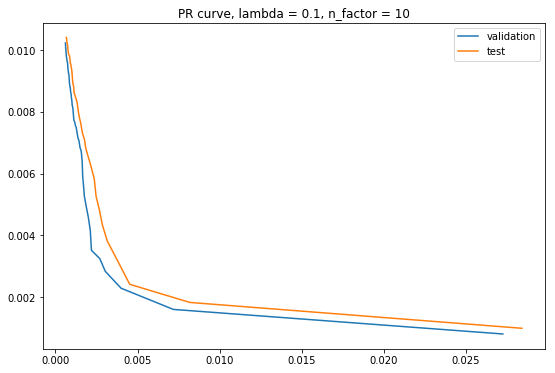

In [24]:
fig, axes = plt.subplots(1,1,figsize=(9,6))

axes.plot(precision, recall,'-',label="validation")
axes.plot(precision_test, recall_test,'-', label="test")
axes.set_title('PR curve, lambda = 0.1, n_factor = 10')
axes.legend()
fig.savefig('svd_pr_k.eps')

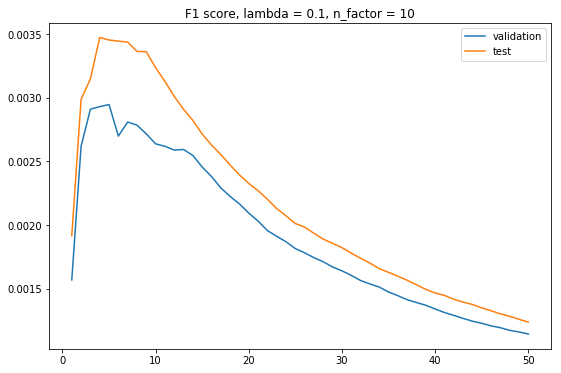

In [25]:
fig, axes = plt.subplots(1,1,figsize=(9,6))

axes.plot(klist, f1,'-', label="validation")
axes.plot(klist, f1_test,'-', label="test")
axes.set_title('F1 score, lambda = 0.1, n_factor = 10')
axes.legend()
fig.savefig('svd_f1_k.eps')

## Aggregate Diversity

In [ ]:
k = 3
user_reclist_first_k = dict()
print(len(user_reclist_dict_test.keys()))
for u in user_reclist_dict_test.keys():
   user_reclist_first_k[u] = user_reclist_dict_test[u][:k]
 
print(list(user_reclist_dict_test.keys())[0], user_reclist_first_k[list(user_reclist_dict_test.keys())[0]])
print(3070721, user_reclist_first_k[3070721])


In [ ]:
dict_for_aggregate  = utils.invert_dict(user_reclist_first_k)
# print(dict_for_aggregate[2160922])
aggregate_diversity = len(dict_for_aggregate.keys())
print(aggregate_diversity)

In [ ]:
print(user_reclist_dict_test[user_ids[0]])
print(user_reclist_first_k[user_ids[0]])

## Dicovery Ratio

In [ ]:
klist = [1,3,15]
for t,k in enumerate(klist):
    user_reclist_first_k = dict()
    for u in user_reclist_dict_test.keys():
       user_reclist_first_k[u] = user_reclist_dict_test[u][:k]
    discov = dict()
    for u in user_reclist_first_k.keys():
        discov[u] = (k - len([j for j in range(k) if user_reclist_dict_test[u][j] in testdict[u]]))/k
    discov[t] = sum(dis for dis in discov.values()) / len(discov)
    print(discov[t])

## Example recommendation

In [ ]:
def get_paper_names_given_numbering(datadir='../dblp-ref'):
    # When using surprise, it seems like we don't need this method.
    # This method assigns nonnegative integer numbers to each paper id,
    # and record it in a dictionary for efficient lookup.
    DBLP_LIST = [ datadir+'/dblp-ref-0.json',
        datadir+'/dblp-ref-1.json',
        datadir+'/dblp-ref-2.json',
        datadir+'/dblp-ref-3.json' ]
    
    name = dict()
    current_id = 0

    for data in DBLP_LIST:
        with open(data) as f:
            line = f.readline()
            while line:
                data = json.loads(line)
                name[current_id]   = data["title"]
                current_id += 1
                line = f.readline()

    return name
import json
name = get_paper_names_given_numbering()

In [ ]:
k = 5
user_reclist_first_k = dict()
user_ids_test = list(testdict.keys())
print(len(user_ids_test))

for u in user_reclist_dict_test.keys():
   user_reclist_first_k[u] = user_reclist_dict_test[u][:k]

In [ ]:
for u in user_ids_test:
    temp = [j for j in range(k) if user_reclist_dict_test[u][j] in testdict[u]]
    if len(temp) > 0:
        print(name[u])
        for j in range(k):
            if j in temp:
                print('   *', name[user_reclist_first_k[u][j]])
            else:
                print('    ', name[user_reclist_first_k[u][j]])

In [18]:
import math

In [19]:
def ndcg(recs, gt):
    '''
    input: 1. recs = recommendation list for one user.
                recs = 
           2. gt = ratings of a user in the test set.
                gt = a dictionary of lists with (key = each user) and (value = a list of items for this user)
           
    output: ndcg for a MODEL (not for each user) with a specific setting.
    '''
    Q, S = 0.0, 0.0
    for u, vs in gt.items():
        rec = recs.get(u, [])
        if not rec:
            continue

        idcg = sum([1.0 / math.log(i + 2, 2) for i in range(len(vs))])
        dcg = 0.0
        for i, r in enumerate(rec):
            if r not in vs:
                continue
            rank = i + 1
            dcg += 1.0 / math.log(rank + 1, 2)
        ndcg = dcg / idcg
        S += ndcg
        Q += 1
    return S / Q

In [24]:
k = 50
user_reclist_first_k = dict()
for u in user_reclist_dict_test.keys():
    user_reclist_first_k[u] = user_reclist_dict_test[u][:k]

In [25]:
ndcg(user_reclist_first_k,testdict)

0.006034940308555286